
=== Enhanced EDA for Insurance Classification Dataset ===

Class Distribution:
charges
1    0.5
0    0.5
Name: proportion, dtype: float64


<Figure size 1200x800 with 0 Axes>

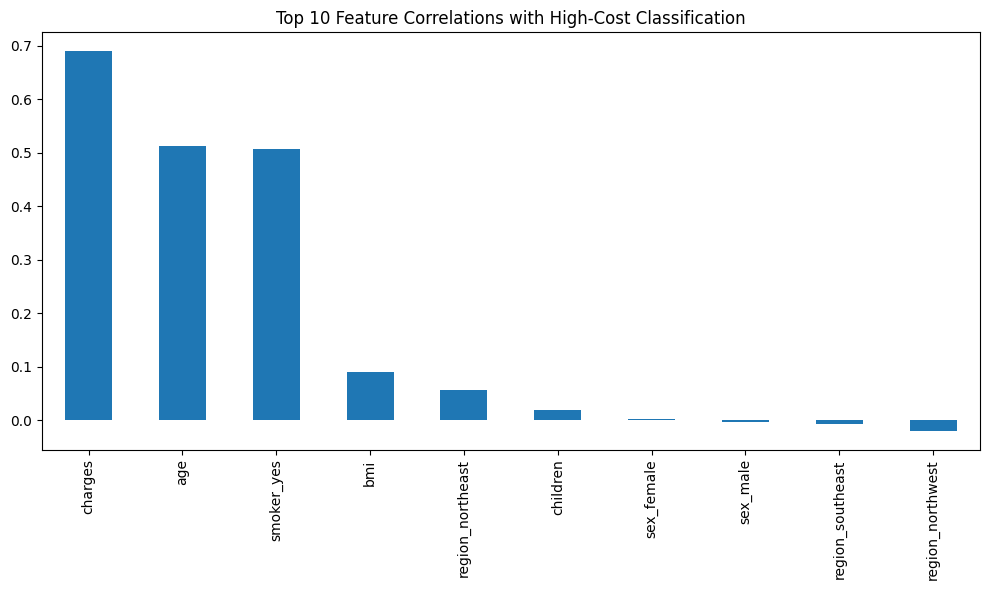

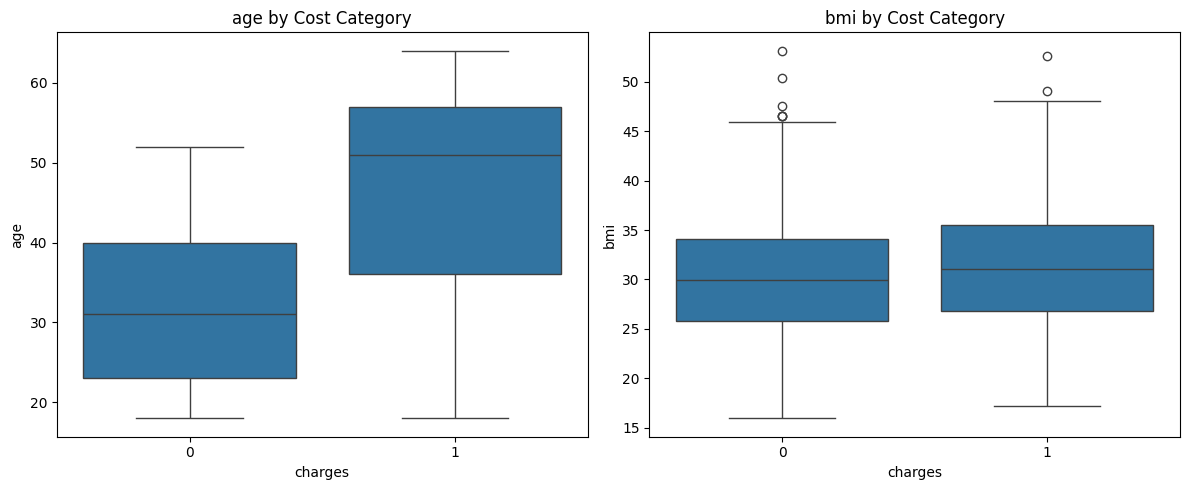


Custom Logistic Regression Accuracy: 0.917910447761194

Selected Classification Features: ['age', 'bmi', 'smoker_no', 'smoker_yes', 'region_northeast']

=== Classification Results ===

Random Forest:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9142

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       146
           1       0.92      0.89      0.90       122

    accuracy                           0.91       268
   macro avg       0.91      0.91      0.91       268
weighted avg       0.91      0.91      0.91       268


SVM:
Best Parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.9216

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       146
           1       0.91      0.92      0.91       122

    accuracy                           0.92       268


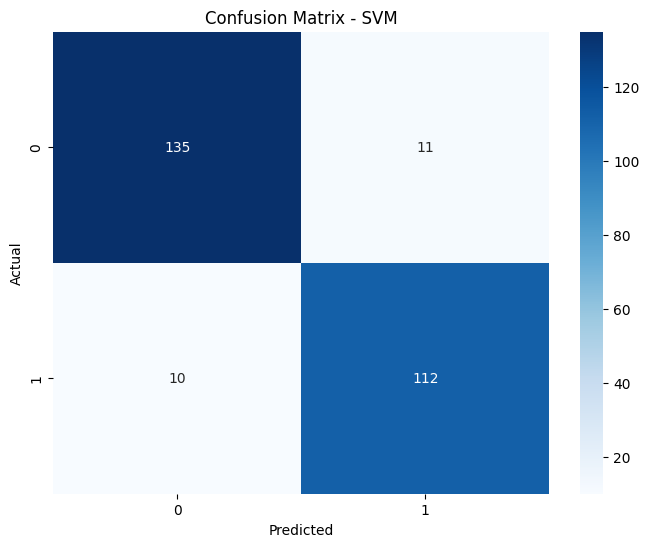


=== Final Classification Conclusions ===
Best performing model: SVM
Best accuracy: 0.9216
Most important features: age, bmi, smoker_no

Best model parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

# Load and preprocess the insurance dataset
df = pd.read_csv('/content/drive/MyDrive/DATASETS/insurance.csv')

# Convert categorical variables to numeric
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'])

# Create binary classification target (1 for high-cost, 0 for low-cost)
median_charge = df['charges'].median()
y = (df['charges'] > median_charge).astype(int)
X = df.drop('charges', axis=1)

# Enhanced EDA for Classification Task
print("\n=== Enhanced EDA for Insurance Classification Dataset ===")
print("\nClass Distribution:")
print(y.value_counts(normalize=True))

# Correlation analysis
plt.figure(figsize=(12, 8))
df['high_cost'] = y
correlation_matrix = df.corr()['high_cost'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
correlation_matrix[1:11].plot(kind='bar')
plt.title('Top 10 Feature Correlations with High-Cost Classification')
plt.tight_layout()
plt.show()

# Box plots for numerical features by class
numerical_cols = ['age', 'bmi']
plt.figure(figsize=(12, 5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=y, y=df[col])
    plt.title(f'{col} by Cost Category')
plt.tight_layout()
plt.show()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build Logistic Regression from Scratch
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(z)

            # Gradient descent
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        return (y_pred >= 0.5).astype(int)

# Train custom logistic regression
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X_train_scaled, y_train)
custom_pred = custom_log_reg.predict(X_test_scaled)
print("\nCustom Logistic Regression Accuracy:",
      accuracy_score(y_test, custom_pred))

# Feature selection
selector = SelectKBest(score_func=f_classif, k=5)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()
print("\nSelected Classification Features:", selected_features)

# Train multiple classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Hyperparameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'SVM': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    }
}

# Train and evaluate classifiers
clf_results = {}
for name, clf in classifiers.items():
    # Perform GridSearchCV
    grid_search = GridSearchCV(clf, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_selected, y_train)

    # Get best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_selected)

    # Store results
    clf_results[name] = {
        'Best Parameters': grid_search.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Model': best_model
    }

# Print classification results
print("\n=== Classification Results ===")
for name, results in clf_results.items():
    print(f"\n{name}:")
    print(f"Best Parameters: {results['Best Parameters']}")
    print(f"Accuracy: {results['Accuracy']:.4f}")
    print("\nClassification Report:")
    y_pred = results['Model'].predict(X_test_selected)
    print(classification_report(y_test, y_pred))

# Find best performing model
best_clf_name = max(clf_results.items(), key=lambda x: x[1]['Accuracy'])[0]
best_clf = clf_results[best_clf_name]['Model']
y_pred_best = best_clf.predict(X_test_selected)

# Visualize confusion matrix for best model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_best),
            annot=True,
            fmt='d',
            cmap='Blues')
plt.title(f'Confusion Matrix - {best_clf_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance for Random Forest
if best_clf_name == 'Random Forest':
    importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': best_clf.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance, x='Importance', y='Feature')
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()

# Final conclusions
print("\n=== Final Classification Conclusions ===")
print(f"Best performing model: {best_clf_name}")
print(f"Best accuracy: {clf_results[best_clf_name]['Accuracy']:.4f}")
print(f"Most important features: {', '.join(selected_features[:3])}")
print("\nBest model parameters:", clf_results[best_clf_name]['Best Parameters'])